In [9]:
import pandas as pd 
import numpy as np
from sklearn.datasets import load_wine
pd.set_option("display.max_columns", None)

In [10]:
wine = load_wine()

In [11]:
dataset = pd.DataFrame(data=np.c_[wine["data"],wine["target"]],columns=wine["feature_names"]+["target"])

In [12]:
dataset["target"].unique()

array([0., 1., 2.])

andiamo a fare il describe per vedere i range dei valori dei numeri nel dataset

In [13]:
dataset.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


andiamo a gestire la classe target nel nostro dataset, dobbiamo andare a bilanciare i valori delle varie classi nel nostro training set altrimenti il classificatore risulta biased

In [14]:
dataset.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                          float64
dtype: object

In [15]:
dataset["target"].unique()
dataset["target"].value_counts()

1.0    71
0.0    59
2.0    48
Name: target, dtype: int64

in questo caso le classi sono abbastanza bilanciate nel nostro dataset, nel caso in cui i valori non fossero stati così bilanciati il nostro classificatore sarebbe stato biased rispetto alla classe con i valori maggiori:
1) le possibili soluzioni sono la creazione di sample sintetici per la classe di minoranza per andare a gestire questa differenza
2) posso invece riportare il numero dei sample della classe maggioritaria al numero della classe minoritaria per bilanciarle

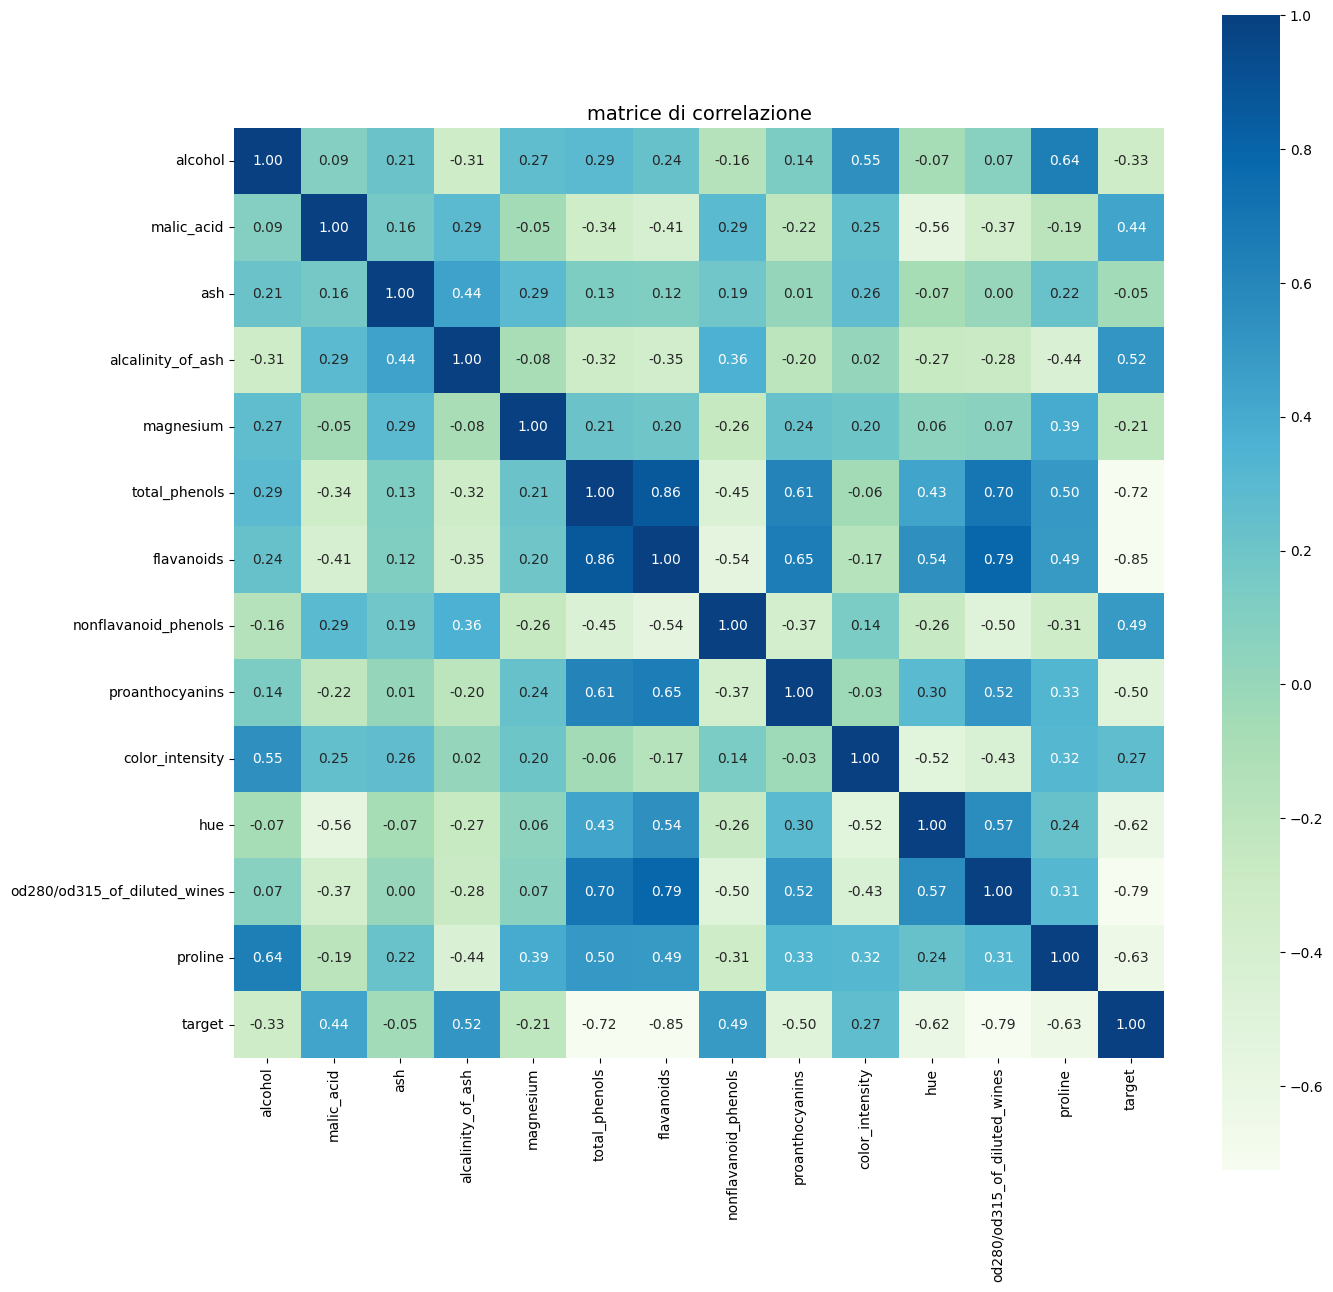

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

corr_matrix = dataset.corr()
plt.figure(figsize=(15,15))
plot = sns.heatmap(corr_matrix, vmax = 1,square = True, annot=True,fmt=".2f", cmap="GnBu",robust = True)

plt.title("matrice di correlazione", fontsize = 14)
plt.show()

vogliamo andare a selezionarne da questa matrice quelle che hanno un valore di correlazione maggiore di una certa soglia, per andare a facilitare il processo di classificazione del nostro classificatore

In [17]:
def remove_unrelated_variability_with_target(df_model,target,threshold ):
    corr = df_model.corr()
    corr_target = abs(corr[target])
    relevant_features = corr_target[corr_target > threshold]
    print("Features con correlazione >",threshold)
    relevant_features
    print("features correlate", len(relevant_features))
    relevant_features_col = relevant_features.keys().tolist()
    
    new_df = df_model[relevant_features_col]
    
    return new_df

Features con correlazione > 0.45
features correlate 9


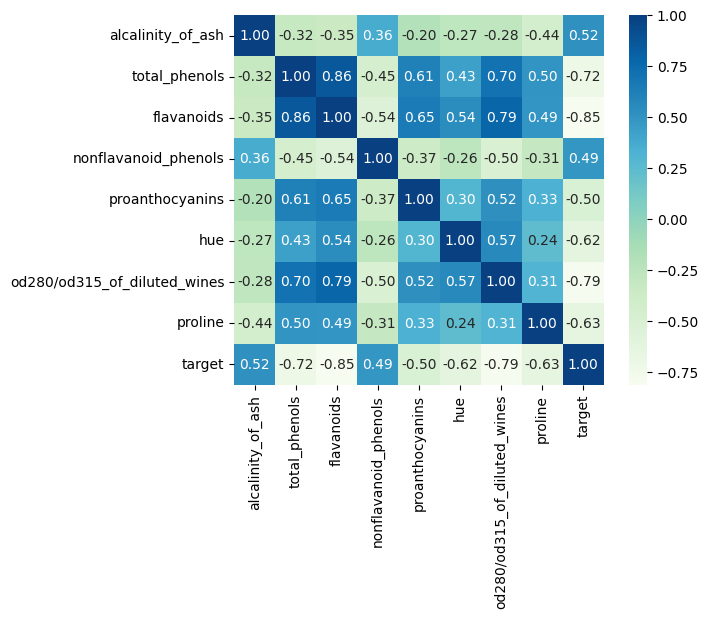

In [18]:
a = remove_unrelated_variability_with_target(dataset,"target",0.45)
matrice = a.corr()
plot = sns.heatmap(matrice, vmax = 1,square = True, annot=True,fmt=".2f", cmap="GnBu",robust = True)

andiamo ora ad effettuare la classificazione sia prima del taglio che dopo il taglio

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

def classificazione(dataframe):
    x = dataframe.drop("target",axis=1)
    y= dataframe["target"]
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,shuffle=True)
    
    y_test.value_counts()
    
    classifier = DecisionTreeClassifier()
    classifier.fit(x_train,y_train)
    y_pred= classifier.predict(x_test)
    
    plt.hist([y_pred,y_test], bins=[0,1,2,3,4,5], label = ["y_pred","y_test"], align = "left")
    plt.xticks([0,1,2])
    plt.yscale("linear")
    plt.title("Decision Tree Classifier")
    plt.legend()
    plt.show()

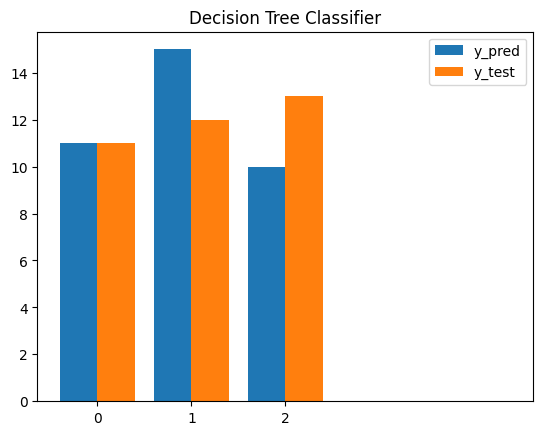

In [20]:
df = classificazione(dataset)

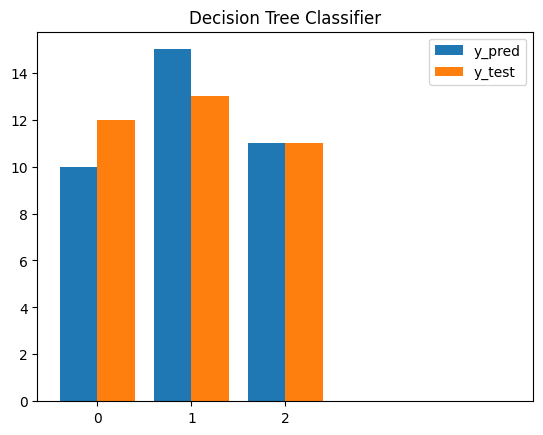

In [21]:
nuovo = classificazione(a)

In [23]:
def classificazione_sampleartificiali(dataframe):
    #print("train counts before:")
    #print("test counts before:")

    x = dataset.drop("target",axis=1)
    y = dataframe["target"]
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,shuffle=True)

    smote = SMOTE(random_state = 3)
    x_train,y_train = smote.fit_resample(x_train,y_train)
    x_test,y_test = smote.fit_resample(x_test,y_test)
    
    #print("train counts: \n",x_train.value_counts())
    #print("test counts: \n", x_test.value_counts())
    
    classifier = DecisionTreeClassifier()
    classifier.fit(x_train,y_train)
    y_pred= classifier.predict(x_test)
    
    plt.hist([y_pred,y_test], bins=[0,1,2,3,4,5], label = ["y_pred","y_test"], align = "left")
    plt.xticks([0,1,2])
    plt.yscale("linear")
    plt.title("Decision Tree Classifier")
    plt.legend()
    plt.show()

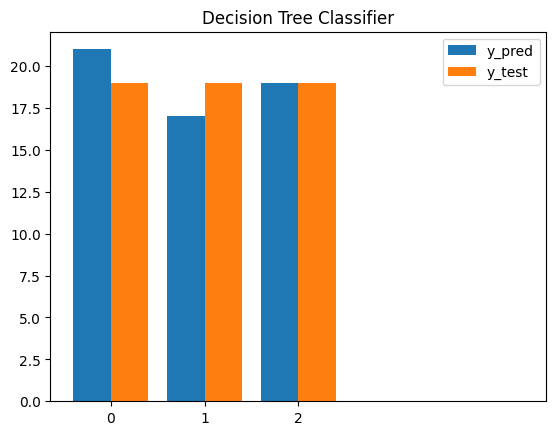

In [24]:
classificazione_sampleartificiali(dataset)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report


def evaluate_decision_tree(df):
    # Separare la feature matrix X dal target vector y
    X = df.drop('target', axis=1)
    y = df['target']
    
    # Sottoporre il dataset a SMOTE per bilanciare le classi
    sm = SMOTE()
    X_resampled, y_resampled = sm.fit_resample(X, y)
    
    # Dividere il dataset in training e test set
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Inizializzare un oggetto DecisionTreeClassifier e addestrarlo sul training set
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    
    # Calcolare le metriche di valutazione sul test set
    y_pred = dt.predict(X_test)
    precision = precision_score(y_test, y_pred,average='macro')
    recall = recall_score(y_test, y_pred,average='macro')
    f_score = f1_score(y_test, y_pred,average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Eseguire la cross validation per ottenere la media delle metriche
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(dt, X_resampled, y_resampled, cv=5, scoring=scoring)
    avg_accuracy = scores['test_accuracy'].mean()
    avg_precision = scores['test_precision'].mean()
    avg_recall = scores['test_recall'].mean()
    avg_f_score = scores['test_f1'].mean()
    
    # Stampare le metriche di valutazione, la matrice di confusione e il report di classificazione
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F-score:', f_score)
    print('Confusion matrix:\n', confusion)
    print('Classification report:\n', report)
    print('Average accuracy:', avg_accuracy)
    print('Average precision:', avg_precision)
    print('Average recall:', avg_recall)
    print('Average F-score:', avg_f_score)

In [ ]:
evaluate_decision_tree(dataset)

Accuracy: 0.9767441860465116
Precision: 0.9722222222222222
Recall: 0.9814814814814815
F-score: 0.975983436853002
Confusion matrix:
 [[11  0  0]
 [ 0 14  0]
 [ 1  0 17]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       1.00      1.00      1.00        14
         2.0       1.00      0.94      0.97        18

    accuracy                           0.98        43
   macro avg       0.97      0.98      0.98        43
weighted avg       0.98      0.98      0.98        43

Average accuracy: 0.8968992248062015


C:\Users\renat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\renat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\renat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\renat\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py", line 1954, in precision_score
    p, _, _, _ = precision_recall_fscor